# Add images with no ship instances

In his discussion of next steps, Kyler mentions that ShipRS lacks "background images" (just the sea with no ship instances). Adding these images is useful because they may establish foreground v. background and reduce false positives. YOLO recommends 1% of total images to be background images. For ShipRSImageNet, this would be about 40 images.

In [8]:
import os
from pathlib import Path
import pandas as pd
from PIL import Image

#### Get each image's size

In [13]:
from multiprocessing import Pool
from functools import partial

def get_image_sizes_df(images_path, file_names):
    pool = Pool(processes=len(os.sched_getaffinity(0)))
    image_sizes = pool.map(partial(get_image_size, images_path=images_path), file_names)
    sizes_df = pd.DataFrame(image_sizes)
    return sizes_df

def get_image_size(file_name, images_path):
    image = Image.open(images_path / file_name)
    w, h = image.size
    return {"file_path": file_name, "image_height": h, "image_width": w}

In [14]:
images_path = Path("sea_images")
df = get_image_sizes_df(images_path, os.listdir(images_path))
df.head()

,file_path,image_height,image_width
0,004312.bmp,500,496
1,100000988.bmp,343,350
2,004543.bmp,450,450
3,004255.bmp,600,600
4,004497.bmp,480,480


#### Create XML annotations

In [20]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

def prettify(elem):
    """Return a pretty-printed XML string for the Element."""
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="    ")

def write_annotation(file_name, image_width, image_height, output_dir):
    annotation = ET.Element('annotation')
    
    annotator = ET.SubElement(annotation, 'annotator')
    annotator.text = "zikun liu"
    
    source = ET.SubElement(annotation, 'source')
    # Empty tag; it's unclear what database HRSC2016 images come from
    database = ET.SubElement(source, 'database')
    dataset_source = ET.SubElement(source, 'dataset_source')
    dataset_source.text = "HRSC2016"

    # Empty tag; HRSC2016 images don't have an associated port id
    port_id = ET.SubElement(annotation, 'port_id')

    img_resolution = ET.SubElement(annotation, 'Img_Resolution')
    # Image resolutions range from 2-m and 0.4-m per pixel, therefore 1.2-m per pixel is the average
    img_resolution.text = "1.2"

    folder_elem = ET.SubElement(annotation, 'folder')
    folder_elem.text = "images"

    filename_elem = ET.SubElement(annotation, 'filename')
    filename_elem.text = f'{file_name}.bmp'

    # All xView images have been sliced to have an image width and height of 930x930
    size = ET.SubElement(annotation, 'size')
    width_elem = ET.SubElement(size, 'width')
    width_elem.text = str(image_width)
    height_elem = ET.SubElement(size, 'height')
    height_elem.text = str(image_height)
    # Empty tag; unsure what depth means
    depth_elem = ET.SubElement(size, 'depth')

    # Convert the annotation to a pretty-printed XML string
    xml_str = prettify(annotation)
    
    file_path = os.path.join(output_dir, f'{file_name}.xml')
    
    # Write the XML string to the file
    with open(file_path, 'w') as f:
        f.write(xml_str)

In [21]:
annotation_output_dir = Path("tmp_sea_xml")

for _, row in df.iterrows():
    write_annotation(row["file_path"][:-4], row["image_width"], row["image_height"], annotation_output_dir)

#### Split these images among ShipRS image sets

In [23]:
import random
import math

def get_splits():
    # Get images that we wish to add to existing image sets (listed in tmp_images folder)
    images_cp = os.listdir(images_path)
    random.shuffle(images_cp)

    # Calculate the number of images to add to each set
    num_images = len(images_cp)
    num_train = math.ceil(0.64 * num_images)
    num_val = math.ceil(0.16 * num_images)

    # Split images into their respective sets
    train_images = images_cp[:num_train]
    val_images = images_cp[num_train:num_train + num_val]
    test_images = images_cp[num_train + num_val:]

    return train_images, val_images, test_images

# Define function to append image names to the specified file
def append_to_image_set(image_set_path, filenames):
    with open(image_set_path, 'a') as file:
        for name in filenames:
            file.write(name + "\n")

Before adding these empty sea images into the image sets:
- `train.txt` stopped at line 2232 (`1824__155.bmp`)
- `val.txt` stopped at line 559 (`2009__121.bmp`)
- `test.txt` stopped at line 696 (`1824__142.bmp`)

In [32]:
train_images, val_images, test_images = get_splits()

# Append the new image names to the respective files
image_sets_dir = Path("ShipRSImageNet_V1/VOC_Format/ImageSets")
# append_to_image_set(os.path.join(image_sets_dir, "train.txt"), train_images)
# append_to_image_set(os.path.join(image_sets_dir, "val.txt"), val_images)
# append_to_image_set(os.path.join(image_sets_dir, "test.txt"), test_images)

# print(f"Added {len(train_images)} images to train.txt, {len(val_images)} images to val.txt, and {len(test_images)} images to test.txt.")

Added 26 images to train.txt, 7 images to val.txt, and 7 images to test.txt.


Now, to finish integration of these new images into ShipRSImageNet then we need to copy over all images in `sea_images` into JPEGImages folder and `tmp_sea_xml` into Annotations folder

    cp sea_images/* ShipRSImageNet_V1/VOC_Format/JPEGImages/
    cp tmp_sea_xml/* ShipRSImageNet_V1/VOC_Format/Annotations/

### Validate images have been transferred successfully

In [33]:
from shiprsimagenet import ShipRSImageNet

dataset = ShipRSImageNet('ShipRSImageNet_V1')
train_set = dataset.get_image_set('train')

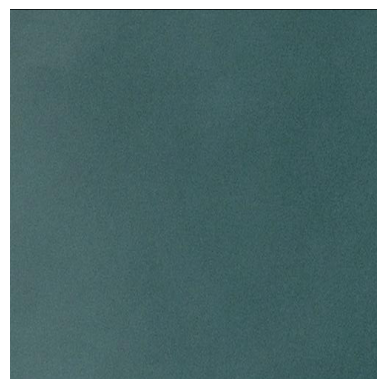

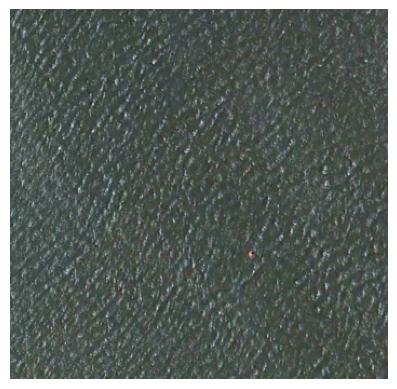

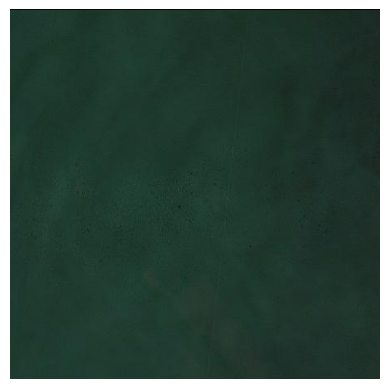

In [36]:
for _, row in df.head(3).iterrows():
    image = dataset.get_image(row["file_path"])
    image.show()